In [1]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import yuGANoh_with_fc_and_disc
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import zipfile

In [2]:
#initialize transform
transform = transforms.Compose([
    transforms.Resize((428,321)),
    transforms.ToTensor()
])

In [3]:
#initialize dataloader
root_dir = 'C:/Users/micha/Desktop/old_files/card'
batch_size = 45
ygoDset = yuGANoh_with_fc_and_disc.YGO_Dataset(root_dir=root_dir,transform = transform)
ygoLoader = DataLoader(ygoDset, batch_size=batch_size, shuffle=True, num_workers=4)

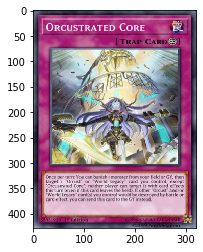

In [4]:
#preview data
batch = next(iter(ygoLoader))
trans = transforms.ToPILImage()
plt.imshow(trans(batch[0]))

In [5]:
#network params
latent_size = 50
num_gan_features = 32
num_disc_features = num_gan_features
num_hidden_features = 256
lr = .0001
beta1 = 0.5
num_epochs = 100
similarity_features = 50
lower_bound = 0.8
bound = 1- lower_bound

In [6]:
#initialize network
device = torch.device('cuda:0')
gen = yuGANoh_with_fc_and_disc.Generator(latent_size,num_gan_features).to(device)
disc = yuGANoh_with_fc_and_disc.Discriminator(num_disc_features,num_hidden_features,similarity_features).to(device)
gen.apply(yuGANoh_with_fc_and_disc.init_weights)
print(gen)
disc.apply(yuGANoh_with_fc_and_disc.init_weights)
print(disc)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 256, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(3, 3), padding=(3, 2), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(64, 64, kernel_size=(5, 5), stride=(3, 3), padding=(3, 2), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(3, 3), padding=(4

C:\Users\micha\Desktop\GitHub\Yu-GAN-Oh\yuGANoh_with_fc_and_disc.py:121: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)


In [7]:
#initialize loss and optimizer
criterion = nn.BCELoss()
noise = torch.randn(1,latent_size,1,1).to(device)
optimizerD = optim.Adam(disc.parameters(),lr=lr,betas=(beta1,0.999), weight_decay = .0001)
optimizerG = optim.Adam(gen.parameters(),lr=2*lr,betas=(beta1,0.999), weight_decay = .0001)

In [8]:
def feature_loss(real_features,fake_features):
    temp = torch.mean(real_features,axis=0) - torch.mean(fake_features,axis=0)
    return torch.sum(temp*temp)

In [9]:
def check_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is None:
            continue
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    print(total_norm)
    
def normalize_tensors(inp):
    return (inp-0.5)*2

def undo_normalize(inp):
    return inp/2 + 0.5

def check_individual_norm(model):
    for p in model.parameters():
        if p.grad is None:
            print(str(p.name)+' is None')
            continue
        print(str(p.name) +': '+  str(p.grad.data.norm(2).item()**2))

Begin training
Epoch: 0 iter: 0 lossG: 122.79772186279297 lossD: 1.4973914623260498


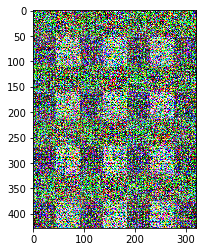

discriminator gradient L2 Norm
1441.6900342906476
generator gradient L2 Norm
1131.3839633927394
Epoch: 0 iter: 50 lossG: 93.25604248046875 lossD: 0.49348026514053345


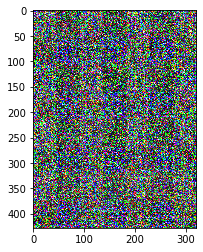

discriminator gradient L2 Norm
1412.5643266855618
generator gradient L2 Norm
1075.2090510764963
Epoch: 0 iter: 100 lossG: 193.36383056640625 lossD: 0.9293543100357056


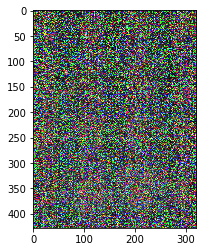

discriminator gradient L2 Norm
1970.2543724180439
generator gradient L2 Norm
1532.520987081868
Epoch: 0 iter: 150 lossG: 72.28656005859375 lossD: 1.1597139835357666


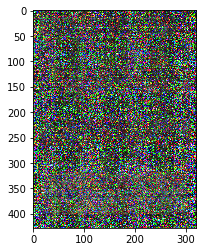

discriminator gradient L2 Norm
1202.5794903326257
generator gradient L2 Norm
954.3620793229152
Epoch: 0 iter: 200 lossG: 40.025386810302734 lossD: 0.9401434063911438


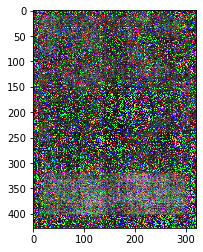

discriminator gradient L2 Norm
582.2641864690966
generator gradient L2 Norm
473.60345004284744
Epoch: 1 iter: 0 lossG: 37.941463470458984 lossD: 0.7116767168045044


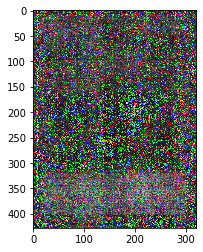

discriminator gradient L2 Norm
623.0813733960149
generator gradient L2 Norm
520.5423638419614
Epoch: 1 iter: 50 lossG: 52.799217224121094 lossD: 0.6808834671974182


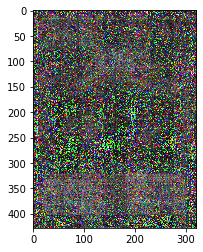

discriminator gradient L2 Norm
763.2351035680525
generator gradient L2 Norm
665.6546875837777
Epoch: 1 iter: 100 lossG: 54.08123016357422 lossD: 1.157944917678833


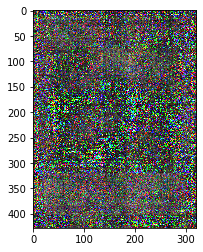

discriminator gradient L2 Norm
805.6466489332856
generator gradient L2 Norm
708.0197697403361
Epoch: 1 iter: 150 lossG: 39.69349670410156 lossD: 1.022624135017395


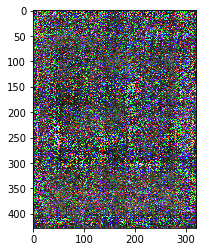

discriminator gradient L2 Norm
666.6916486101146
generator gradient L2 Norm
545.3223275881603
Epoch: 1 iter: 200 lossG: 30.10921287536621 lossD: 1.2222816944122314


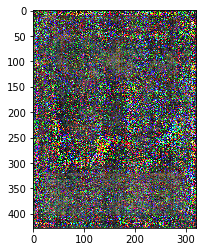

discriminator gradient L2 Norm
508.22073850435527
generator gradient L2 Norm
380.4182878282557
Epoch: 2 iter: 0 lossG: 37.160255432128906 lossD: 0.9268331527709961


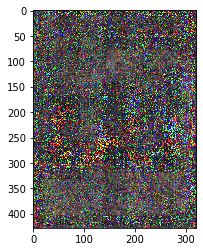

discriminator gradient L2 Norm
502.6383271136049
generator gradient L2 Norm
415.2410826754586
Epoch: 2 iter: 50 lossG: 36.603912353515625 lossD: 0.6698751449584961


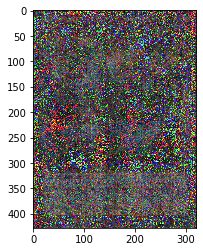

discriminator gradient L2 Norm
447.77743009645985
generator gradient L2 Norm
456.15623318298475
Epoch: 2 iter: 100 lossG: 31.154361724853516 lossD: 0.7270895838737488


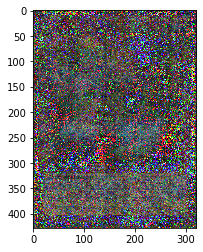

discriminator gradient L2 Norm
395.56420143339477
generator gradient L2 Norm
341.0489280688296
Epoch: 2 iter: 150 lossG: 38.360652923583984 lossD: 0.9261250495910645


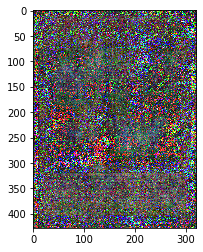

discriminator gradient L2 Norm
426.4547406425728
generator gradient L2 Norm
404.33857875737755
Epoch: 2 iter: 200 lossG: 31.571815490722656 lossD: 0.5898315906524658


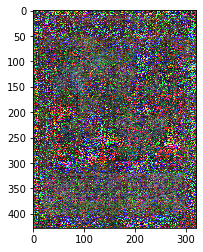

discriminator gradient L2 Norm
450.44367371933487
generator gradient L2 Norm
353.84206904070504
Epoch: 3 iter: 0 lossG: 27.57296371459961 lossD: 0.693274736404419


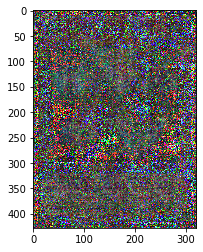

discriminator gradient L2 Norm
417.5745127200136
generator gradient L2 Norm
331.93298117525444
Epoch: 3 iter: 50 lossG: 38.548255920410156 lossD: 0.6607896685600281


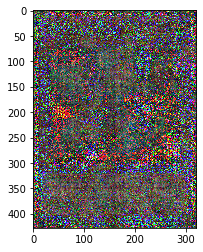

discriminator gradient L2 Norm
395.0648014483707
generator gradient L2 Norm
476.77394514144703
Epoch: 3 iter: 100 lossG: 23.360549926757812 lossD: 0.5564379692077637


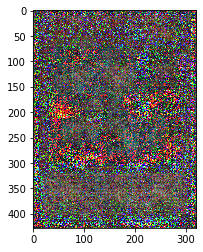

discriminator gradient L2 Norm
325.7611505212666
generator gradient L2 Norm
256.63100158759534
Epoch: 3 iter: 150 lossG: 19.55842399597168 lossD: 0.8918931484222412


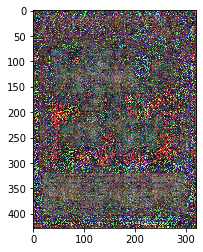

discriminator gradient L2 Norm
243.58364076786475
generator gradient L2 Norm
299.9804417906461
Epoch: 3 iter: 200 lossG: 18.595970153808594 lossD: 1.148085355758667


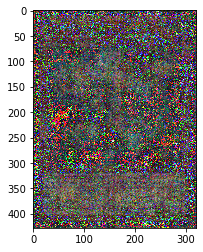

discriminator gradient L2 Norm
250.18565663454885
generator gradient L2 Norm
279.2418753171223
Epoch: 4 iter: 0 lossG: 18.17418670654297 lossD: 0.8561468124389648


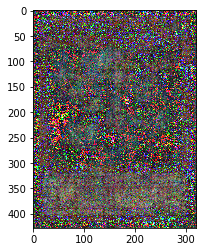

discriminator gradient L2 Norm
266.1253619316651
generator gradient L2 Norm
262.0617536259627
Epoch: 4 iter: 50 lossG: 19.753952026367188 lossD: 0.7179024815559387


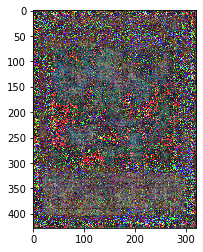

discriminator gradient L2 Norm
261.0473832860386
generator gradient L2 Norm
328.22462143388185
Epoch: 4 iter: 100 lossG: 21.58673095703125 lossD: 0.9781625866889954


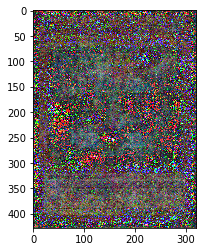

discriminator gradient L2 Norm
282.94460911305265
generator gradient L2 Norm
275.06250462056755


KeyboardInterrupt: 

In [10]:
images = []
gen_losses = []
disc_losses = []

torch.autograd.set_detect_anomaly(True)

print("Begin training")
for epoch in range(num_epochs):
    for i,img in enumerate(ygoLoader,0):
        #zero discriminator gradient
        disc.zero_grad()
        
        
        #run real image through discriminator
        img = img.to(device)
        #img = normalize_tensors(img) + 0.1*torch.randn_like(img).to(device)
        if epoch < 15:
            img = img + 0.1*torch.randn_like(img).to(device)
        b_size = img.shape[0]
        features_real, output = disc(img)
        output = output.squeeze()
        #real_label = 1
        #label = torch.ones_like(output).to(device)
        label = 1 - bound*torch.rand_like(output)
        disc_loss_real = criterion(output,label)
        disc_loss_real.backward()
        
        
        #now run a fake batch through generator.
        inp = torch.randn(b_size,latent_size,1,1).to(device)
        gen_out = gen(inp)
        features_fake, fake_out = disc(gen_out)
        fake_out = fake_out.squeeze()
        #fake_label = 0
        label_fake = label*0
        disc_loss_fake = criterion(fake_out,label_fake)
        disc_loss_fake.backward()
        total_loss = disc_loss_real + disc_loss_fake       
        optimizerD.step()
        
        # train the generator
        # we already have a generator pass with gen_out=gen(inp)
        gen.zero_grad()
        disc.zero_grad()
        gen_out = gen(inp)
        features_real, real_out = disc(img)
        features_fake, fake_out = disc(gen_out)
        model_loss = feature_loss(features_real,features_fake)
        model_loss.backward()
        optimizerG.step()
        '''
        #train the generator again
        #we already have a generator pass with gen_out=gen(inp)
        gen.zero_grad()
        features_out_real , model_out = disc(gen_out)
        model_out = model_out.squeeze()
        model_loss = feature_loss(features_out_real,features_fake)
        model_loss.backward()   
        optimizerG.step()'''
        
        #check_individual_norm(gen)
        #check_individual_norm(disc)
        
        if i%50 == 0:
            disc_losses.append(total_loss.item())
            gen_losses.append(model_loss.item())
            print('Epoch: '+str(epoch) + ' iter: ' + str(i) + ' lossG: ' + str(gen_losses[-1]) + ' lossD: ' + str(disc_losses[-1]))
            out_img = gen(noise)
            #out_img = undo_normalize(out_img)
            trans = transforms.ToPILImage()
            plt.imshow(trans(out_img[0].cpu()))
            plt.show()
            if gen_losses[-1] == 0.0:
                break
            if disc_losses[-1] == 0.0:
                break
            print('discriminator gradient L2 Norm')
            check_norm(disc)
            print('generator gradient L2 Norm')
            check_norm(gen)

In [ ]:
noise = torch.randn(1,latent_size,1,1).to(device)
out_img = gen(noise)
#out_img = undo_normalize(out_img)
trans = transforms.ToPILImage()
plt.imshow(trans(out_img[0].cpu()))

In [ ]:
plt.plot(disc_losses)
plt.plot(gen_losses)
plt.legend(['disc_losses','gen_losses'])
plt.show()

In [ ]:
torch.save(gen.state_dict(), 'gen22.pt')
torch.save(disc.state_dict(), 'disc22.pt')

In [ ]:
torch.save(disc_losses,'disc22_loss_weight-dec_2.pt')

In [ ]:
torch.save(gen_losses,'gen22_loss_weight-dec_2.pt')

In [ ]:
E = torch.randn(3*2,3,4)
A = torch.randn(4,3*2)
A.transpose(0,1)

In [ ]:
A = torch.Tensor([[[1,1],[2,2]],[[3,3],[4,4]],[[2,1],[2,4]],[[11,3],[4,3]]])
A = A.transpose(0,2)
print(A.shape)
A = A.repeat(A.shape[2],1,1,1)
print(A.shape)
B = A.transpose(0,-1)
print(B.shape)
C = torch.exp(-torch.sum(torch.abs(B-A),dim=2))
print(C.shape)
D = torch.sum(C,dim = 2)
print(D.shape)
print(D[0])
print(D[1])

In [ ]:
A = torch.randn(3,2)
print(A.shape)
print(A)
torch.sum(A,dim=1)